In [45]:
from torch.nn.functional import normalize
from GraphAwareNestedCVEvaluation import GraphAwareNestedCVEvaluation
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import add_self_loops
from hyperopt import hp
import numpy as np
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
import shap
import torch
from NestedCV import index_to_mask

In [26]:
cora_dataset = Planetoid(root='data/', name='Cora', split="public")
cora_dataset.transform = T.NormalizeFeatures()
cora_dataset[0].edge_index = add_self_loops(dataset[0].edge_index)[0]

citeseer_dataset = Planetoid(root='data/', name='CiteSeer', split="public")
citeseer_dataset.transform = T.NormalizeFeatures()
citeseer_dataset[0].edge_index = add_self_loops(citeseer_dataset[0].edge_index)[0]

pubmed_dataset = Planetoid(root='data/', name='PubMed', split="public")
pubmed_dataset.transform = T.NormalizeFeatures()
pubmed_dataset[0].edge_index = add_self_loops(pubmed_dataset[0].edge_index)[0]

'PubMed'

In [27]:
def norm_user_function(kwargs):
    return  normalize(kwargs["original_features"] + kwargs["summed_neighbors"], p=2.0, dim = 1)
    
def user_function(kwargs):
    return  kwargs["original_features"] + kwargs["summed_neighbors"]
    
class ModelSpace():
    def __init__(self):
        self.space = None
        self.initialize_space()

    def initialize_space(self):
        framework_choices = {
            'hops': [[0, 3, 8], [0, 1, 2]],
            'attention_config': [None,{'inter_layer_normalize': False,
                     'use_pseudo_attention':True,
                     'cosine_eps':.01,
                     'dropout_attn': None}, 
                     {'inter_layer_normalize': True,
                     'use_pseudo_attention':True,
                     'cosine_eps':.01,
                     'dropout_attn': None},
                     {'inter_layer_normalize': True,
                     'use_pseudo_attention':True,
                     'cosine_eps':.001,
                     'dropout_attn': None}],
            'user_function': [norm_user_function, user_function],
        }
         
        self.space = {
            **{key: hp.choice(key, value) for key, value in framework_choices.items()}
        }
        
    def add_choice(self, key, items):
        self.space[key] = hp.choice(key, items)
        
    def add_uniform(self, key, limits: tuple):
        self.space[key] = hp.uniform(key, limits[0], limits[1])
        
    def add_loguniform(self, key, limits: tuple):
        self.space[key] = hp.loguniform(key, np.log(limits[0]), np.log(limits[1]))
        
    def add_qloguniform(self, key, limits, q):
        self.space[key] = hp.qloguniform(key, low=np.log(limits[0]), high=np.log(limits[1]), q=q)

class LogitsticRegressionSpace(ModelSpace):
    def __init__(self):
        super().__init__()

    def get_space(self):
        self.add_loguniform('tol', [6e-3, 4e-2])
        self.add_uniform('C', [0, 10])
        return self.space    

In [28]:
lr_space = LogitsticRegressionSpace()

In [31]:
store = dict({})

In [32]:
for dataset in [citeseer_dataset, pubmed_dataset, cora_dataset]:
    data = dataset[0]
    graph_aware_nestedCV_evaluation = GraphAwareNestedCVEvaluation(2, LogisticRegression, data, max_evals= len(lr_space.get_space().keys())*20)
    graph_aware_nestedCV_evaluation.nested_cross_validate(3, 3, lr_space.get_space())
    store[dataset.name] = graph_aware_nestedCV_evaluation.nested_transd_cv

0it [00:00, ?it/s]

/home/dwalke/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/dwalke/git/graph_aware_ml/EnsembleFramework.py:328: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:231.)
  summed_exp_score = torch.zeros_like(exp_score).scatter(0, target,exp_score, reduce="add")
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing

0it [00:00, ?it/s]

/home/dwalke/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/dwalke/git/graph_aware_ml/EnsembleFramework.py:328: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:231.)
  summed_exp_score = torch.zeros_like(exp_score).scatter(0, target,exp_score, reduce="add")
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing

0it [00:00, ?it/s]

/home/dwalke/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/dwalke/git/graph_aware_ml/EnsembleFramework.py:328: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:231.)
  summed_exp_score = torch.zeros_like(exp_score).scatter(0, target,exp_score, reduce="add")
/home/dwalke/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/dwalke/git/graph_aware_ml/EnsembleFramework.py:328: UserWarning:

In [33]:
for item in store:
    print(f"""
    {item}:\n
    {store[item]}
    """)


    CiteSeer:

    
        Using a 3 x 3 nested StratifiedKFold Cross-Validation, we obtain:
        0.7716 +- 0.0171.

        self.outer_scores: [0.77457169 0.74932372 0.79080252]

        self.best_params_per_fold: [{'C': 2.503275461884442, 'attention_config': {'cosine_eps': 0.01, 'dropout_attn': None, 'inter_layer_normalize': False, 'use_pseudo_attention': True}, 'hops': (0, 1, 2), 'tol': 0.006578485193921385, 'user_function': <function norm_user_function at 0x7fec449d6f80>}, {'C': 3.9165033032086365, 'attention_config': {'cosine_eps': 0.01, 'dropout_attn': None, 'inter_layer_normalize': False, 'use_pseudo_attention': True}, 'hops': (0, 3, 8), 'tol': 0.01197854586862398, 'user_function': <function user_function at 0x7fec449d7eb0>}, {'C': 2.3588384405685012, 'attention_config': {'cosine_eps': 0.001, 'dropout_attn': None, 'inter_layer_normalize': True, 'use_pseudo_attention': True}, 'hops': (0, 1, 2), 'tol': 0.009965768207422152, 'user_function': <function user_function at 0x7fec44

In [8]:
graph_aware_nestedCV_evaluation.nested_transd_cv.outer_scores.mean()

0.8873693584413948

In [24]:
graph_aware_nestedCV_evaluation.nested_transd_cv.inner_scores

array([[0.89036545, 0.87873754, 0.87853577],
       [0.88538206, 0.86378738, 0.86023295],
       [0.8820598 , 0.88039867, 0.89036545]])

In [10]:
graph_aware_nestedCV_evaluation.nested_transd_cv.best_params_per_fold

[{'C': 9.888414965183856,
  'attention_config': None,
  'hops': (0, 3, 8),
  'tol': 0.0061029838756099415,
  'user_function': <function __main__.norm_user_function(kwargs)>},
 {'C': 3.4614191808169488,
  'attention_config': None,
  'hops': (0, 3, 8),
  'tol': 0.011995183118874127,
  'user_function': <function __main__.norm_user_function(kwargs)>},
 {'C': 9.210974208311047,
  'attention_config': None,
  'hops': (0, 3, 8),
  'tol': 0.02779843230971727,
  'user_function': <function __main__.norm_user_function(kwargs)>}]

In [11]:
print(graph_aware_nestedCV_evaluation.nested_transd_cv)


        Using a 3 x 3 nested StratifiedKFold Cross-Validation, we obtain:
        0.8874 +- 0.0094.

        self.outer_scores: [0.87818383 0.90033223 0.88359202]

        self.best_params_per_fold: [{'C': 9.888414965183856, 'attention_config': None, 'hops': (0, 3, 8), 'tol': 0.0061029838756099415, 'user_function': <function norm_user_function at 0x7feaeee416c0>}, {'C': 3.4614191808169488, 'attention_config': None, 'hops': (0, 3, 8), 'tol': 0.011995183118874127, 'user_function': <function norm_user_function at 0x7feaeee416c0>}, {'C': 9.210974208311047, 'attention_config': None, 'hops': (0, 3, 8), 'tol': 0.02779843230971727, 'user_function': <function norm_user_function at 0x7feaeee416c0>}]

        self.best_models: [<EnsembleFramework.Framework object at 0x7fed1fbd7970>, <EnsembleFramework.Framework object at 0x7fec44805b40>, <EnsembleFramework.Framework object at 0x7feaeed391e0>]

        


[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:2'),
 tensor([[0.0024, 0.0040, 0.0091,  ..., 0.0000, 0.0862, 0.0018],
         [0.0000, 0.0007, 0.0022,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0008, 0.0018,  ..., 0.0002, 0.0025, 0.0002],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0037, 0.0031, 0.0048,  ..., 0.0000, 0.0000, 0.0028],
         [0.0041, 0.0025, 0.0056,  ..., 0.0000, 0.0000, 0.0081]],
        device='cuda:2'),
 tensor([[0.0026, 0.0077, 0.0132,  ..., 0.0003, 0.0518, 0.0060],
         [0.0005, 0.0020, 0.0038,  ..., 0.0005, 0.0091, 0.0016],
         [0.0012, 0.0052, 0.0100,  ..., 0.0006, 0.0073, 0.0022],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0042

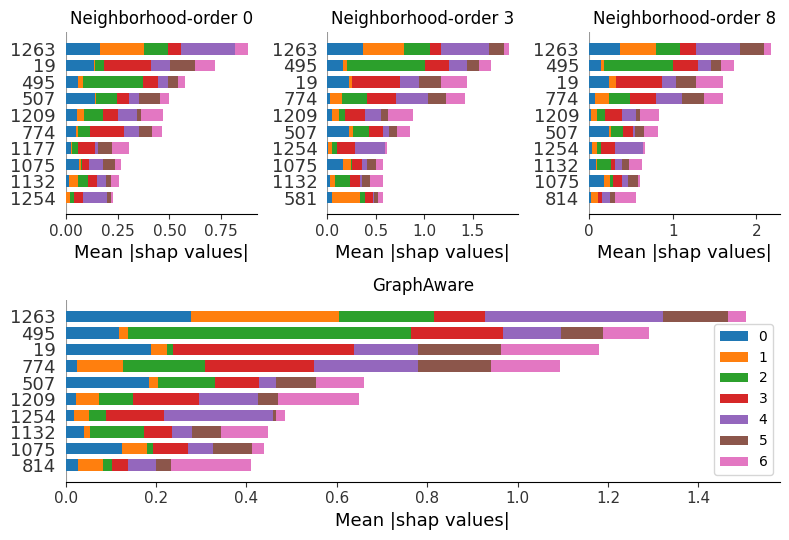

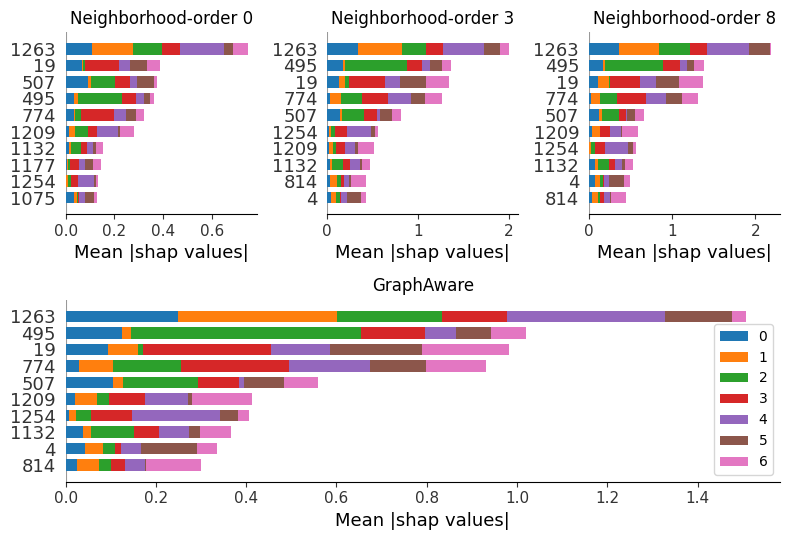

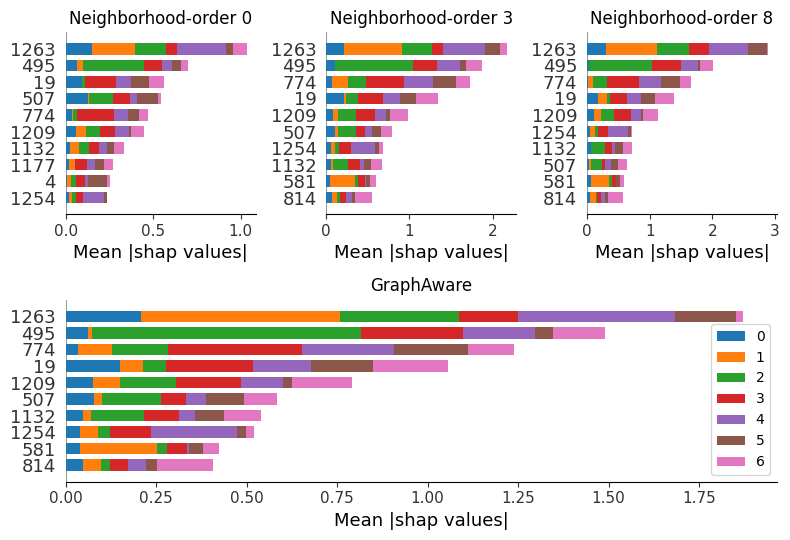

In [224]:
import matplotlib.pyplot as plt

class_colors = {
     0: '#1f77b4',  # Blue
    1: '#ff7f0e',  # Orange
    2: '#2ca02c',  # Green
    3: '#d62728',  # Red
    4: '#9467bd',  # Purple
    5: '#8c564b',  # Brown
    6: '#e377c2'   # Pink
}

for split_index, (train_index, test_index) in enumerate(store["Cora"].kf_outer.split(data.x, data.y)):
    train_mask = index_to_mask(data.x.shape[0], train_index)
    test_mask = index_to_mask(data.x.shape[0], test_index)
    background_datasets = store["Cora"].best_models[split_index].get_features(data.x, data.edge_index, train_mask, is_training=True)
    test_data = store["Cora"].best_models[split_index].get_features(data.x, data.edge_index, test_mask, is_training=False)
    shap_store = []
    fig =  plt.figure(figsize=(30, 15))
    gs = fig.add_gridspec(2, 3)
    
    for background_data_index, background_data in enumerate(background_datasets):
        explainer = shap.LinearExplainer(store["Cora"].best_models[split_index].trained_clfs[background_data_index], background_data.cpu().numpy())
        data_to_explain = test_data[background_data_index].cpu().numpy()
        shap_values_ex = explainer.shap_values(data_to_explain) #[0]
        shap_store.append(shap_values_ex)
        
        feature_names = [j for j in range(data_to_explain.shape[-1])]
        class_names = [i for i in range(7)]
        hop = store["Cora"].best_models[split_index].hops_list[background_data_index]

        ax = fig.add_subplot(gs[0, background_data_index])
        plt.sca(ax)
        shap.summary_plot(shap_values_ex, class_names= class_names, feature_names = feature_names, plot_type="bar", show=False, max_display=10, color = lambda i: class_colors[i],
                         class_inds='original')
        ax.set_xlabel("Mean |shap values|")
        ax.set_title(f"Neighborhood-order {hop}")
        ax.get_legend().remove()
        
    shap_values_avg = np.array(shap_store).mean(0)
    shap_values_avg = [shap_values_avg[i, :, :] for i in range(shap_values_avg.shape[0])]
    ax = fig.add_subplot(gs[1, :])
    plt.sca(ax)
    shap.summary_plot(shap_values_avg, plot_type="bar", class_names= class_names, feature_names = feature_names, max_display=10, color = lambda i: class_colors[i],
                         class_inds='original', show = False)
    ax.set_xlabel("Mean |shap values|")
    ax.set_title(f"GraphAware")
    ax.legend(fontsize=10, loc='lower right')
    plt.tight_layout()
    plt.show()